# Comparison of real HPL executions, fixed matrix size

In [1]:
import io
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    result = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    result['index'] = range(len(result))
    result['jobid'] = get_yaml(archive_name, 'info.yaml')['jobid']
    result['filename'] = archive_name
    return result

def read_result(name):
    result = read_csv(name, 'results.csv')
    return result

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

executions = [
    'grenoble_2019-03-19_1856083.zip',
    'grenoble_2019-03-19_1856085.zip',
    'grenoble_2019-03-19_1856093.zip',
    'grenoble_2019-03-19_1856105.zip',
]
df = pandas.concat([read_result(f) for f in executions])
df.head()

,bcast,block_size,depth,filename,gflops,index,jobid,matrix_size,mem_align,pfact,proc_p,proc_q,process_per_node,residual,rfact,start_timestamp,stop_timestamp,swap,thread_per_process,time
0,2,128,1,grenoble_2019-03-19_1856083.zip,22190.0,0,1856083,175000,8,1,32,32,32,0.000827,2,NaN,NaN,0,1,161.04
1,2,128,1,grenoble_2019-03-19_1856083.zip,21500.0,1,1856083,175000,8,1,32,32,32,0.000827,2,NaN,NaN,0,1,166.21
2,2,128,1,grenoble_2019-03-19_1856083.zip,20950.0,2,1856083,175000,8,1,32,32,32,0.000827,2,NaN,NaN,0,1,170.52
3,2,128,1,grenoble_2019-03-19_1856083.zip,20540.0,3,1856083,175000,8,1,32,32,32,0.000827,2,NaN,NaN,0,1,173.93
4,2,128,1,grenoble_2019-03-19_1856083.zip,20640.0,4,1856083,175000,8,1,32,32,32,0.000827,2,NaN,NaN,0,1,173.13


### Checking the parameters

In [2]:
name_exceptions = {'time', 'gflops', 'residual', 'matrix_size', 'mode', 'index', 'start_timestamp', 'stop_timestamp', 'jobid', 'filename'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,mem_align,bcast,pfact,proc_q,proc_p,process_per_node,depth,swap,block_size,rfact,thread_per_process
0,8,2,1,32,32,32,1,0,128,2,1


### Checking the OS version

In [3]:
for version_name in ['version', 'gcc', 'mpi', 'kernel', 'cpu']:
    for filename in executions:
        info = get_yaml(filename, 'info.yaml')
        hostnames = [key for key in info.keys() if key.startswith('dahu')]
        versions = set([info[h][version_name] for h in hostnames])
        assert len(versions) == 1
        print(versions.pop())
    print()

Linux version 4.9.0-8-amd64 (debian-kernel@lists.debian.org) (gcc version 6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.110-3+deb9u4 (2018-08-21)
Linux version 4.9.0-8-amd64 (debian-kernel@lists.debian.org) (gcc version 6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.110-3+deb9u4 (2018-08-21)
Linux version 4.9.0-8-amd64 (debian-kernel@lists.debian.org) (gcc version 6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.110-3+deb9u4 (2018-08-21)
Linux version 4.9.0-8-amd64 (debian-kernel@lists.debian.org) (gcc version 6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.110-3+deb9u4 (2018-08-21)

6.3.0
6.3.0
6.3.0
6.3.0

mpirun (Open MPI) 2.0.2
mpirun (Open MPI) 2.0.2
mpirun (Open MPI) 2.0.2
mpirun (Open MPI) 2.0.2

4.9.0-8-amd64
4.9.0-8-amd64
4.9.0-8-amd64
4.9.0-8-amd64

Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz
Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz
Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz
Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz



### Comparing the executions

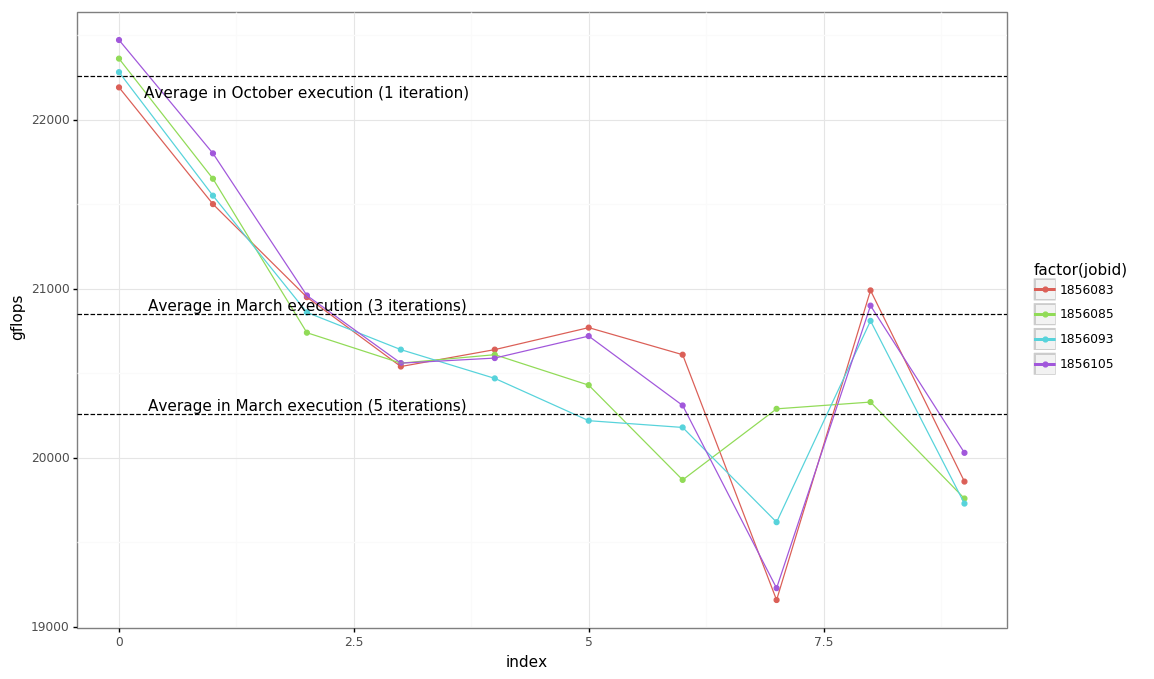

<ggplot: (-9223363257030380256)>

In [4]:
plot = ggplot(df, aes(x='index', y='gflops', color='factor(jobid)')) + geom_point() + geom_line() + theme_bw()
plot = plot + geom_hline(yintercept=22260.0, linetype='dashed') + annotate('text', label='Average in October execution (1 iteration)', x=2, y=22260-100, color='black')
plot = plot + geom_hline(yintercept=20258.0, linetype='dashed') + annotate('text', label='Average in March execution (5 iterations)', x=2, y=20258+50, color='black')
plot = plot + geom_hline(yintercept=20850.0, linetype='dashed') + annotate('text', label='Average in March execution (3 iterations)', x=2, y=20850+50, color='black')
plot

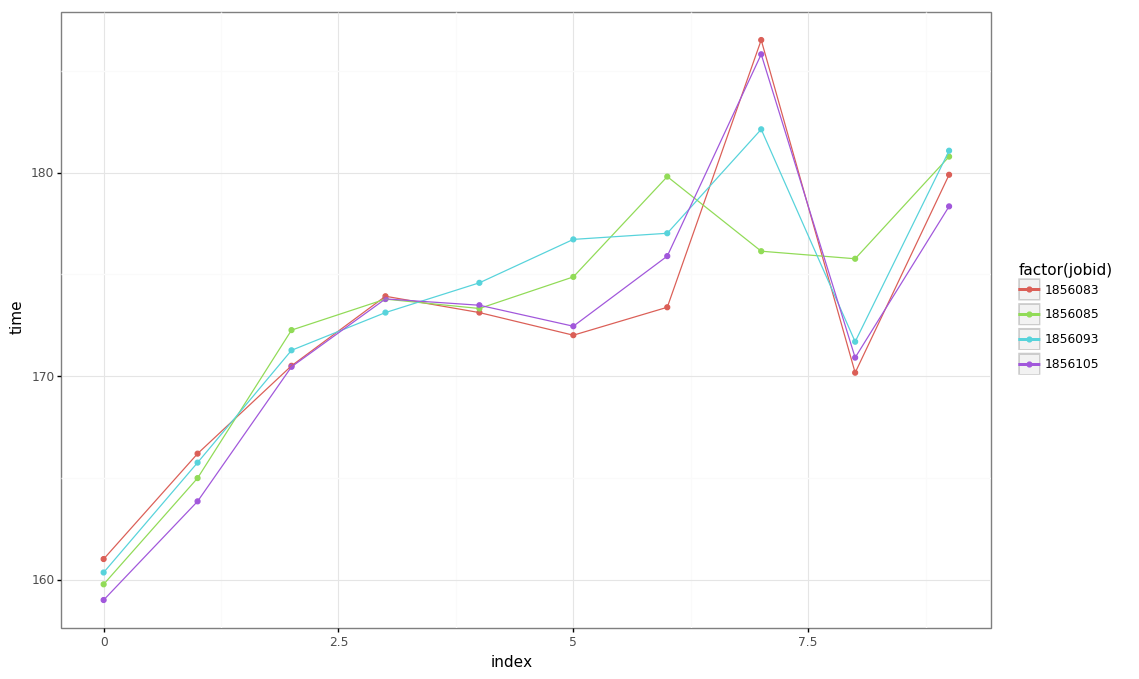

<ggplot: (-9223363257030330231)>

In [5]:
ggplot(df, aes(x='index', y='time', color='factor(jobid)')) + geom_point() + geom_line() + theme_bw()

### Looking at the temperature

The first executions did not have any temperature information. Let's restrict ourselves to the later ones.

In [6]:
df = df[~df.start_timestamp.isnull()].copy()
filenames = df.filename.unique()
temperatures = pandas.concat([read_csv(f, 'temperatures.csv') for f in filenames])
df['start_timestamp'] = pandas.to_datetime(df['start_timestamp'])
df['stop_timestamp'] = pandas.to_datetime(df['stop_timestamp'])
temperatures['timestamp'] = pandas.to_datetime(temperatures['timestamp'])

# Changing the timestamps to a relative time since the start of the job
for jobid in df['jobid'].unique():
    mask = df['jobid'] == jobid
    print('Job %s: %s - %s' % (jobid, df[mask].start_timestamp.min(), df[mask].stop_timestamp.max()))
    first_time = min(df[mask].start_timestamp.min(), temperatures[temperatures['jobid'] == jobid].timestamp.min())
    df.loc[mask, 'start_timestamp'] -= first_time
    df.loc[mask, 'stop_timestamp'] -= first_time
    temperatures.loc[temperatures['jobid'] == jobid, 'timestamp'] -= first_time

Job 1856105: 2019-03-19 15:30:54.382244 - 2019-03-19 16:00:26.051179


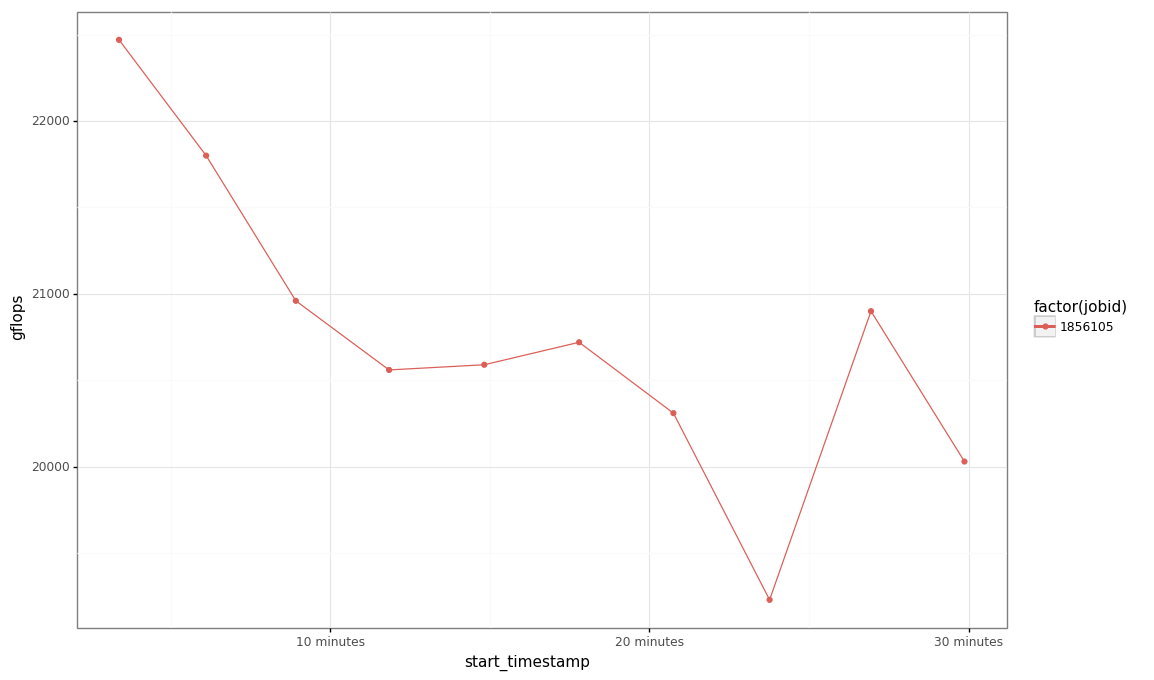

<ggplot: (-9223363257022772939)>

In [7]:
plot = ggplot(df, aes(x='start_timestamp', y='gflops', color='factor(jobid)')) + geom_point() + geom_line() + theme_bw()
plot

In [8]:
temperatures['hostname'] = temperatures.hostname.str[:-21]  # keeping only the prefix, removing '.grenoble.grid5000.fr'
temperatures.head()

,timestamp,hostname,temperature,sensor_id,index,jobid,filename
0,0 days,dahu-7,52.0,0,0,1856105,grenoble_2019-03-19_1856105.zip
1,0 days,dahu-7,38.0,1,1,1856105,grenoble_2019-03-19_1856105.zip
2,0 days,dahu-19,42.0,0,2,1856105,grenoble_2019-03-19_1856105.zip
3,0 days,dahu-19,32.0,1,3,1856105,grenoble_2019-03-19_1856105.zip
4,0 days,dahu-20,40.0,0,4,1856105,grenoble_2019-03-19_1856105.zip


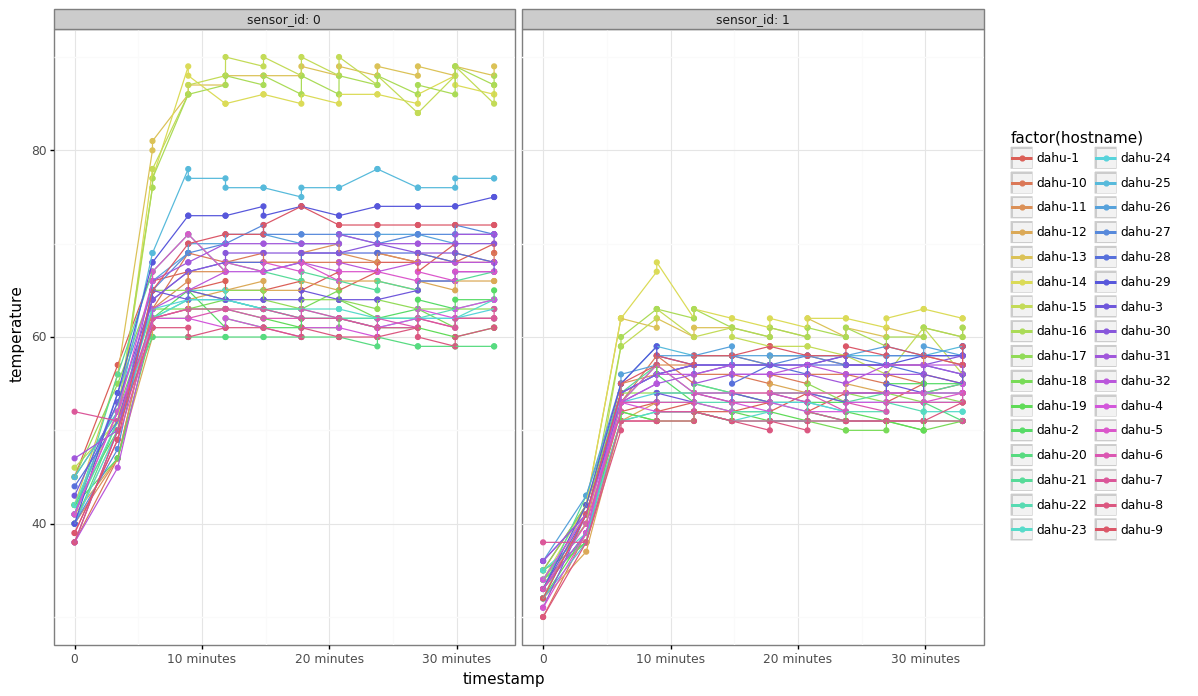

<ggplot: (8779760762667)>

In [9]:
plot = ggplot(temperatures, aes(x='timestamp', y='temperature', color='factor(hostname)')) + geom_point() + geom_line() + theme_bw() + facet_wrap('sensor_id', labeller='label_both')
plot

In [10]:
list(sorted(temperatures[temperatures['temperature'] > 80].hostname.unique()))

['dahu-13', 'dahu-14', 'dahu-15', 'dahu-16']